# GoogleNet

<img src="https://i.imgur.com/g5fRr89.png" width=1000/>

- [source paper](https://arxiv.org/abs/1409.4842)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import datasets, layers, Model, Sequential, losses

In [ ]:
(x_train, y_train), (x_test ,y_test) = datasets.mnist.load_data()

x_train = tf.expand_dims(x_train, axis=3, name=None)
x_test = tf.expand_dims(x_test, axis=3, name=None)
print(f'x_train shape:{x_train.shape}')
print(f'x_test shape:{x_test.shape}')
print('----------')

x_train = tf.repeat(x_train, 3, axis=3)
x_test = tf.repeat(x_test, 3, axis=3)
print(f'x_train shape:{x_train.shape}')
print(f'x_test shape:{x_test.shape}')
print('----------')

x_val = x_train[int(x_train.shape[0]*0.8):,:,:,:]
y_val = y_train[int(y_train.shape[0]*0.8):]
x_train = x_train[:int(x_train.shape[0]*0.8),:,:,:]
y_train = y_train[:int(y_train.shape[0]*0.8)]
print(f'x_train shape:{x_train.shape}, x_val shape:{x_val.shape}')
print(f'y_train shape:{y_train.shape}, y_val shape:{y_val.shape}')

x_train shape:(60000, 28, 28, 1)
x_test shape:(10000, 28, 28, 1)
----------
x_train shape:(60000, 28, 28, 3)
x_test shape:(10000, 28, 28, 3)
----------
x_train shape:(48000, 28, 28, 3), x_val shape:(12000, 28, 28, 3)
y_train shape:(48000,), y_val shape:(12000,)


In [ ]:
labels_num = 10
batch_size = 256
epochs = 10

<img src="https://i.imgur.com/4xLmfqx.png" width=1000/>

- [source paper](https://arxiv.org/abs/1409.4842)

* ## API function

In [ ]:
def inception_block(x, filters_1x1,
           filters_3x3_reduce, filters_3x3,
           filters_5x5_reduce, filters_5x5,
           filters_pooling):
  
  path_1 = layers.Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)

  path_2 = layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
  path_2 = layers.Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(path_2)

  path_3 = layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
  path_3 = layers.Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(path_3)

  path_4 = layers.MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
  path_4 = layers.Conv2D(filters_pooling, (1, 1), padding='same', activation='relu')(path_4)

  return tf.concat([path_1, path_2, path_3, path_4], axis=3)

In [ ]:
def auxiliary_classifier(inputs):
  aux = layers.AveragePooling2D((5, 5), strides=3)(inputs)
  aux = layers.Conv2D(128, 1, padding='same', activation='relu')(aux)
  aux = layers.Flatten()(aux)
  aux = layers.Dense(1024, activation='relu')(aux)
  aux = layers.Dropout(0.7)(aux)
  outputs = layers.Dense(10, activation='softmax')(aux)
  
  return outputs

In [ ]:
inputs = layers.Input(shape=x_train.shape[1:])
x = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=x_train.shape[1:])(inputs)
x = layers.Conv2D(64, (7, 7), strides=2, padding='same', activation='relu')(x)
x = layers.MaxPooling2D((3, 3), strides=2)(x)
x = layers.Conv2D(64, (1, 1), strides=1, padding='same', activation='relu')(x)
x = layers.Conv2D(192, (3, 3), strides=1, padding='same', activation='relu')(x)
x = layers.MaxPooling2D((3, 3), strides=2)(x)

inception_3a = inception_block(x, filters_1x1=64,
                filters_3x3_reduce=96, filters_3x3=128,
                filters_5x5_reduce=16, filters_5x5=32,
                filters_pooling=32)

inception_3b = inception_block(inception_3a, filters_1x1=128,
                filters_3x3_reduce=128, filters_3x3=192,
                filters_5x5_reduce=32, filters_5x5=96,
                filters_pooling=64)
inception_3b = layers.MaxPooling2D((3, 3), strides=2)(inception_3b)

inception_4a = inception_block(inception_3b, filters_1x1=192,
                filters_3x3_reduce=96, filters_3x3=208,
                filters_5x5_reduce=16, filters_5x5=48,
                filters_pooling=64)

aux_1 = auxiliary_classifier(inception_4a)

inception_4b = inception_block(inception_4a, filters_1x1=160,
                 filters_3x3_reduce=112, filters_3x3=224,
                 filters_5x5_reduce=24, filters_5x5=64,
                 filters_pooling=64)

inception_4c = inception_block(inception_4b, filters_1x1=128,
                 filters_3x3_reduce=128, filters_3x3=256,
                 filters_5x5_reduce=24, filters_5x5=64,
                 filters_pooling=64)

inception_4d = inception_block(inception_4c, filters_1x1=112,
                 filters_3x3_reduce=144, filters_3x3=288,
                 filters_5x5_reduce=32, filters_5x5=64,
                 filters_pooling=64)

aux_2 = auxiliary_classifier(inception_4d)

inception_4e = inception_block(inception_4d, filters_1x1=256,
                 filters_3x3_reduce=160, filters_3x3=320,
                 filters_5x5_reduce=32, filters_5x5=128,
                 filters_pooling=128)

inception_4e = layers.MaxPooling2D((3, 3), strides=2)(inception_4e)

inception_5a = inception_block(inception_4e, filters_1x1=256,
                 filters_3x3_reduce=160, filters_3x3=320,
                 filters_5x5_reduce=32, filters_5x5=128,
                 filters_pooling=128)

inception_5b = inception_block(inception_5a, filters_1x1=384,
                 filters_3x3_reduce=192, filters_3x3=384,
                 filters_5x5_reduce=48, filters_5x5=128,
                 filters_pooling=128)

outputs = layers.GlobalAveragePooling2D()(inception_5b)
outputs = layers.Dropout(0.4)(outputs)
outputs = layers.Dense(labels_num, activation='softmax')(outputs)

In [ ]:
GoogleNet_model = Model(inputs = inputs, outputs = [outputs, aux_1, aux_2])

In [ ]:
GoogleNet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 resizing (Resizing)            (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['resizing[0][0]']               
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 55, 55, 64)   0           ['conv2d[0][0]']             

In [ ]:
inputs = np.ones((batch_size, x_train.shape[1], x_train.shape[2], 3), dtype=np.float32)
GoogleNet_model(inputs).shape

AttributeError: ignored

In [ ]:
GoogleNet_model(inputs)

[<tf.Tensor: shape=(256, 10), dtype=float32, numpy=
 array([[0.09975607, 0.10035147, 0.10068595, ..., 0.09976226, 0.09950839,
         0.10021024],
        [0.09975606, 0.10035146, 0.10068595, ..., 0.09976225, 0.09950837,
         0.10021023],
        [0.09975607, 0.10035147, 0.10068595, ..., 0.09976226, 0.09950839,
         0.10021024],
        ...,
        [0.09975606, 0.10035146, 0.10068595, ..., 0.09976225, 0.09950837,
         0.10021023],
        [0.09975607, 0.10035147, 0.10068595, ..., 0.09976226, 0.09950839,
         0.10021024],
        [0.09975606, 0.10035146, 0.10068595, ..., 0.09976225, 0.09950837,
         0.10021023]], dtype=float32)>,
 <tf.Tensor: shape=(256, 10), dtype=float32, numpy=
 array([[0.10111584, 0.10062047, 0.09805156, ..., 0.0978609 , 0.1004513 ,
         0.1003069 ],
        [0.10111584, 0.10062047, 0.09805156, ..., 0.0978609 , 0.1004513 ,
         0.1003069 ],
        [0.10111584, 0.10062047, 0.09805156, ..., 0.0978609 , 0.1004513 ,
         0.1003069 ],
 

In [ ]:
len(GoogleNet_model(inputs))

3

In [ ]:
GoogleNet_model(inputs)[0].shape, GoogleNet_model(inputs)[1].shape, GoogleNet_model(inputs)[2].shape

(TensorShape([256, 10]), TensorShape([256, 10]), TensorShape([256, 10]))

In [ ]:
GoogleNet_model.compile(optimizer='adam',
            loss=[losses.sparse_categorical_crossentropy,
               losses.sparse_categorical_crossentropy,
               losses.sparse_categorical_crossentropy],
            loss_weights=[1, 0.2, 0.2],
            metrics=['accuracy'])

history = GoogleNet_model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=batch_size, epochs=epochs)

Epoch 1/10
188/188 [==============================] - 199s 833ms/step - loss: 1.4347 - dense_4_loss: 1.0871 - dense_1_loss: 0.8254 - dense_3_loss: 0.9124 - dense_4_accuracy: 0.6129 - dense_1_accuracy: 0.7476 - dense_3_accuracy: 0.7029 - val_loss: 0.1397 - val_dense_4_loss: 0.1015 - val_dense_1_loss: 0.0950 - val_dense_3_loss: 0.0960 - val_dense_4_accuracy: 0.9700 - val_dense_1_accuracy: 0.9712 - val_dense_3_accuracy: 0.9704
Epoch 2/10
188/188 [==============================] - 140s 745ms/step - loss: 0.1288 - dense_4_loss: 0.0892 - dense_1_loss: 0.1016 - dense_3_loss: 0.0963 - dense_4_accuracy: 0.9731 - dense_1_accuracy: 0.9684 - dense_3_accuracy: 0.9712 - val_loss: 0.0824 - val_dense_4_loss: 0.0599 - val_dense_1_loss: 0.0575 - val_dense_3_loss: 0.0552 - val_dense_4_accuracy: 0.9824 - val_dense_1_accuracy: 0.9829 - val_dense_3_accuracy: 0.9831
Epoch 3/10
188/188 [==============================] - 139s 742ms/step - loss: 0.0743 - dense_4_loss: 0.0479 - dense_1_loss: 0.0713 - dense_3_los

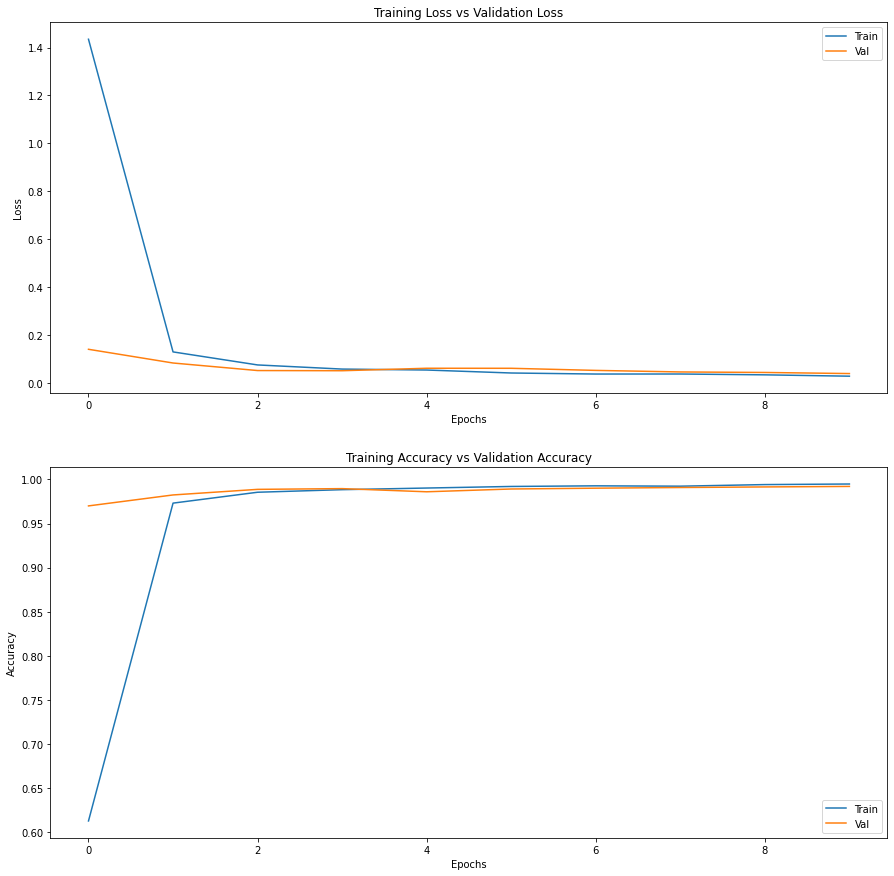

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])

axs[1].plot(history.history['dense_4_accuracy'])
axs[1].plot(history.history['val_dense_4_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

In [ ]:
GoogleNet_model.evaluate(x_test, y_test)

313/313 [==============================] - 12s 35ms/step - loss: 0.0258 - dense_4_loss: 0.0177 - dense_1_loss: 0.0201 - dense_3_loss: 0.0203 - dense_4_accuracy: 0.9950 - dense_1_accuracy: 0.9930 - dense_3_accuracy: 0.9936


[0.025817641988396645,
 0.01774059236049652,
 0.020084286108613014,
 0.020301001146435738,
 0.9950000047683716,
 0.9929999709129333,
 0.9936000108718872]

* ## OOP method

In [ ]:
class AuxiliaryClassifier(layers.Layer):
  def __init__(self, labels_num):
    super(AuxiliaryClassifier, self).__init__()

    self.avg_pooling = layers.AveragePooling2D((5, 5), strides=3)
    self.conv = layers.Conv2D(128, 1, padding='same', activation='relu')
    self.dense = layers.Dense(1024, activation='relu')
    self.dropout = layers.Dropout(0.7)
    self.classifier = layers.Dense(labels_num, activation='softmax')


  def call(self, inputs, training=None):
    aux = self.avg_pooling(inputs)
    aux = self.conv(aux)
    aux = layers.Flatten()(aux)
    aux = self.dense(aux)
    aux = self.dropout(aux)
    outputs = self.classifier(aux)   

    return outputs

In [ ]:
class InceptionBlock(layers.Layer):
  def __init__(self, filters_1x1,
         filters_3x3_reduce, filters_3x3,
         filters_5x5_reduce, filters_5x5,
         filters_pooling):
    super(InceptionBlock, self).__init__()

    self.path_1 = Sequential([layers.Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')])
    
    self.path_2 = Sequential([layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu'),
                         layers.Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')])
    
    self.path_3 = Sequential([layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu'),
                         layers.Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')])
    
    self.path_4 = Sequential([layers.MaxPool2D((3, 3), strides=(1, 1), padding='same'),
                  layers.Conv2D(filters_pooling, (1, 1), padding='same', activation='relu')])


  def call(self, inputs, training=None):
    path_1 = self.path_1(inputs)
    path_2 = self.path_2(inputs)
    path_3 = self.path_3(inputs)
    path_4 = self.path_4(inputs)

    return tf.concat([path_1, path_2, path_3, path_4], axis=3)

In [ ]:
class GoogleNet(tf.keras.Model):
  def __init__(self, input_shape, labels_num=10):
    super(GoogleNet,self).__init__()

    self.conv = Sequential([layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=input_shape),
                  layers.Conv2D(64, (7, 7), strides=2, padding='same', activation='relu'),
                  layers.MaxPooling2D((3, 3), strides=2),
                  layers.Conv2D(64, (1, 1), strides=1, padding='same', activation='relu'),
                  layers.Conv2D(192, (3, 3), strides=1, padding='same', activation='relu'),
                  layers.MaxPooling2D((3, 3), strides=2)])
    
    self.max_pooling = layers.MaxPooling2D((3, 3), strides=2)
    
    self.aux_classifier_1 = AuxiliaryClassifier(labels_num)
    self.aux_classifier_2 = AuxiliaryClassifier(labels_num)

    self.inception_3a = InceptionBlock(filters_1x1=64,
                        filters_3x3_reduce=96, filters_3x3=128,
                        filters_5x5_reduce=16, filters_5x5=32,
                        filters_pooling=32)
    
    self.inception_3b = InceptionBlock(filters_1x1=128,
                        filters_3x3_reduce=128, filters_3x3=192,
                        filters_5x5_reduce=32, filters_5x5=96,
                        filters_pooling=64)
    
    self.inception_4a = InceptionBlock(filters_1x1=192,
                        filters_3x3_reduce=96, filters_3x3=208,
                        filters_5x5_reduce=16, filters_5x5=48,
                        filters_pooling=64)
    
    self.inception_4b = InceptionBlock(filters_1x1=160,
                        filters_3x3_reduce=112, filters_3x3=224,
                        filters_5x5_reduce=24, filters_5x5=64,
                        filters_pooling=64)
    
    self.inception_4c = InceptionBlock(filters_1x1=128,
                        filters_3x3_reduce=128, filters_3x3=256,
                        filters_5x5_reduce=24, filters_5x5=64,
                        filters_pooling=64)
    
    self.inception_4d = InceptionBlock(filters_1x1=112,
                        filters_3x3_reduce=144, filters_3x3=288,
                        filters_5x5_reduce=32, filters_5x5=64,
                        filters_pooling=64)
    
    self.inception_4e = InceptionBlock(filters_1x1=256,
                        filters_3x3_reduce=160, filters_3x3=320,
                        filters_5x5_reduce=32, filters_5x5=128,
                        filters_pooling=128)
    
    self.inception_5a = InceptionBlock(filters_1x1=256,
                        filters_3x3_reduce=160, filters_3x3=320,
                        filters_5x5_reduce=32, filters_5x5=128,
                        filters_pooling=128)
    
    self.inception_5b = InceptionBlock(filters_1x1=384,
                        filters_3x3_reduce=192, filters_3x3=384,
                        filters_5x5_reduce=48, filters_5x5=128,
                        filters_pooling=128)
    
    self.GAP = layers.GlobalAveragePooling2D()
    self.dropout = layers.Dropout(0.4)
    self.classifier = layers.Dense(labels_num, activation='softmax') 

  def call(self, inputs, training=None):
    x = self.conv(inputs)
    x = self.inception_3a(x)       
    x = self.inception_3b(x)
    x = self.max_pooling(x)
    
    x = self.inception_4a(x)
    aux_1 = self.aux_classifier_1(x)
    
    x = self.inception_4b(x)
    x = self.inception_4c(x)
    x = self.inception_4d(x)
    aux_2 = self.aux_classifier_2(x)
    
    x = self.inception_4e(x)
    x = self.max_pooling(x)
    
    x = self.inception_5a(x)       
    x = self.inception_5b(x)
    
    x = self.GAP(x) 
    x = self.dropout(x) 
    outputs = self.classifier(x)
    return outputs

In [ ]:
GoogleNet_model = GoogleNet(input_shape = x_train.shape[1:])

In [ ]:
GoogleNet_model.build((None, x_train.shape[1], x_train.shape[2], x_train.shape[3]))
GoogleNet_model.summary()

Model: "google_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 27, 27, 192)       124416    
                                                                 
 max_pooling2d_15 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 auxiliary_classifier (Auxil  multiple                 1256586   
 iaryClassifier)                                                 
                                                                 
 auxiliary_classifier_1 (Aux  multiple                 1258634   
 iliaryClassifier)                                               
                                                                 
 inception_block (InceptionB  multiple                 163696    
 lock)                                                  

In [ ]:
inputs = np.ones((batch_size, x_train.shape[1], x_train.shape[2], 3), dtype=np.float32)
len(GoogleNet_model(inputs))

256

In [ ]:
GoogleNet_model(inputs)[0].shape, GoogleNet_model(inputs)[1].shape, GoogleNet_model(inputs)[2].shape

(TensorShape([10]), TensorShape([10]), TensorShape([10]))

In [ ]:
GoogleNet_model(inputs)

<tf.Tensor: shape=(256, 10), dtype=float32, numpy=
array([[0.10023454, 0.10036407, 0.10083772, ..., 0.09982296, 0.10036207,
        0.10017226],
       [0.10023452, 0.10036407, 0.10083772, ..., 0.09982295, 0.10036207,
        0.10017224],
       [0.10023454, 0.10036407, 0.10083772, ..., 0.09982296, 0.10036207,
        0.10017226],
       ...,
       [0.10023452, 0.10036407, 0.10083772, ..., 0.09982295, 0.10036207,
        0.10017224],
       [0.10023454, 0.10036407, 0.10083772, ..., 0.09982296, 0.10036207,
        0.10017226],
       [0.10023452, 0.10036407, 0.10083772, ..., 0.09982295, 0.10036207,
        0.10017224]], dtype=float32)>